# <center>EE6770 Fall 2024 Homework 5: Cats and Dogs Classifier</center>

1. __Write comments__ in the code to explain your thoughts.
2. __Important: Execute the codes and show the results__. 
3. __Do your own work.__ 

### Submission:
 * __Submit this notebook file and the pdf version__ - remember to add your name in the filename.
 * Deadline: 11:59 pm, 10/28 (Monday)

## Assignment Objectives:

### In this assignment, you will develop a CNN model for the cat-and-dog classifer. 
#### You will create `at least two models`, applying the various techniques we discussed for improving the performance. 

1. Deeper Conv layers and/or FC layers
2. Image augmentation
3. Transfer learning
4. Regularization: L1/L2, Batch Normalization, Dropout, Max Norm
5. Increasing image size
6. Increasing size of the train/validation/test dataset

* You will compare the performance of your models with the baseline VGG-5 model that we discussed in class.
* <font color=red>Image size is limited to 128-by-128 or smaller </font>
* <font color=red>Performance requirement: the accuracy on the test data needs to be better than 87.5% for at least one of your models </font>

### Cats & Dogs Dataset

* #### You are given a zip file, `train.zip`, that contains 25,000 labelled images of cats and dogs (12,500 each) 
* #### You will select a subset of $N$ image files from the dataset and store them in the following sub-directory structure, where $N$ can be anywhere between 10,000 to 25,000.
* #### The train-validation-test data split is 60%-15%-25%.
<img src="./images/train_test_dir.png" alt="Drawing" style="width: 250px;"/> 

### Load tool modules

In [134]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

print(tf.config.list_physical_devices('GPU'))

[]


### Load CNN models

In [135]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout

### Load the image processing tools 

In [136]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

### Load and Process the dataset
__Create the subdirectory structures per the requirement.__

In [137]:
import os
import shutil

#--------------------------------------#
# Select the number of files to train  #
N = 25000                              #
#--------------------------------------#

source_dir = "./train"
train_dir = "./cats_dogs"

os.makedirs(train_dir, exist_ok=True)

def organize_images(name, start, stop):
    for pet in ("cat", "dog"):
        dir = train_dir + "/" + name + "/" + pet
        os.makedirs(dir, exist_ok=True)

        images = [f"{pet}.{i}.jpg" for i in range(start, stop)]
        for file in images:
            shutil.copy(src=source_dir + '/' + file, dst=dir + '/ '+ file)


N_split = int(25000 / 2)
train_perc = int(N_split * 0.6)
val_percent = train_perc + int(N_split * 0.15)
test_percent = val_percent + int(N_split * 0.25)

organize_images("train", start=0, stop=train_perc)
organize_images("validation", start=train_perc, stop=val_percent)
organize_images("test", start=val_percent, stop=test_percent)

### Display 2 input images: one for dog, and one for cat 

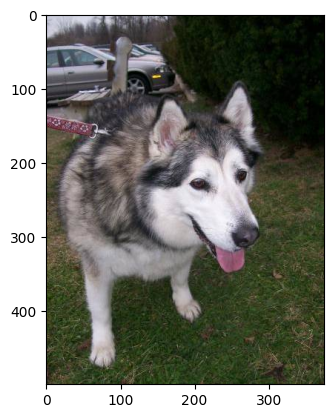

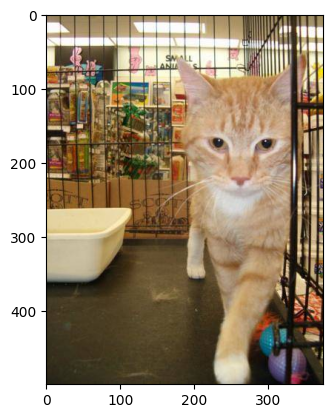

In [138]:
import matplotlib.pyplot as plt
import random


dog_dir = os.listdir(train_dir+'/test'+'/dog')
cat_dir = os.listdir(train_dir+'/test'+'/cat')
dog_sample = random.choice(dog_dir)
cat_sample = random.choice(cat_dir)


dog_img = load_img(os.path.join(train_dir+'/test'+'/dog', dog_sample))
cat_img = load_img(os.path.join(train_dir+'/test'+'/cat', cat_sample))

plt.imshow(dog_img)
plt.show()

plt.imshow(cat_img)
plt.show()

# Baseline CNN Model: VGG-5

In [139]:
# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

# ----------- Target Picture Size ------------ #
target_pic_size = (64, 64)                     #
target_pic_shape = target_pic_size + (3,)      #
# -------------------------------------------- #


train_data = datagen.flow_from_directory(train_dir + '/train',
            class_mode='binary', batch_size=64, target_size=target_pic_size)

val_data = datagen.flow_from_directory(train_dir + '/validation',
           class_mode='binary', batch_size=64, target_size=target_pic_size)

test_data = datagen.flow_from_directory(train_dir + '/test',
            class_mode='binary', batch_size=64, target_size=target_pic_size)


    
model = Sequential()

# Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=target_pic_shape))
model.add(MaxPooling2D((2, 2)))

# Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

# FC Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.summary()





Found 15000 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_194 (Conv2D)             │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_126               │ (None, 31, 31, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_195 (Conv2D)             │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_127               │ (None, 14, 14, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_196 (Conv2D)             │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_128               │ (None, 6, 6, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_53 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [140]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(train_data, epochs=10, batch_size=64, validation_data=val_data, verbose=1)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.5986 - loss: 0.6549 - val_accuracy: 0.7309 - val_loss: 0.5423
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.7439 - loss: 0.5188 - val_accuracy: 0.7891 - val_loss: 0.4618
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.7889 - loss: 0.4504 - val_accuracy: 0.7979 - val_loss: 0.4431
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.8155 - loss: 0.4016 - val_accuracy: 0.7928 - val_loss: 0.4304
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.8407 - loss: 0.3586 - val_accuracy: 0.8176 - val_loss: 0.3904
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.8606 - loss: 0.3099 - val_accuracy: 0.8171 - val_loss: 0.3906
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.8866 - loss: 0.2703 - val_accuracy: 0.8200 - val_loss: 0.4047
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.9062 - loss: 0.2253 - val_accurac

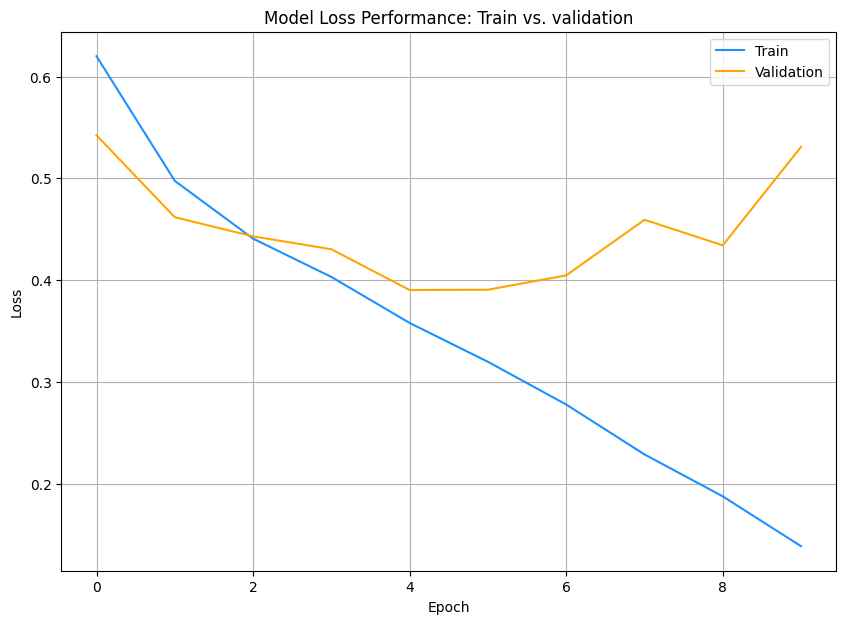

In [141]:
J = history.history['loss']  # Loss data for Training 
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

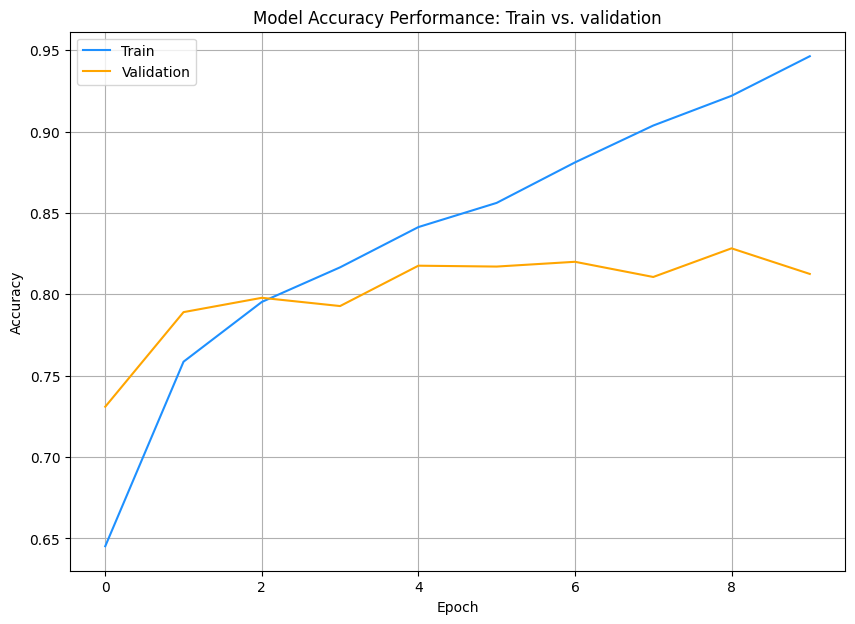

98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8106 - loss: 0.5223
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step


In [142]:
accu = history.history['accuracy']  # Loss data for Training 
accu_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Accuracy Performance: Train vs. validation')
plt.plot(accu, color='DodgerBlue', label='Train')
plt.plot(accu_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

loss, accuracy = model.evaluate(test_data, verbose=1)

y_pred = model.predict(test_data)

# <font color=blue>Build CNN Model One</font>

## <font color=green>Define the CNN model</font> 

__Use CONV, POOL and FC layers to construct your CNN model. You can also load pre-trained model, if transfer learning is used. You will train and test the model after this step.__

In [197]:
# ----------- Target Picture Size ------------ #
target_pic_size = (128, 128)                     #
target_pic_shape = target_pic_size + (3,)      #
# -------------------------------------------- #

train_data = datagen.flow_from_directory(train_dir + '/train',
            class_mode='binary', batch_size=64, target_size=target_pic_size)

val_data = datagen.flow_from_directory(train_dir + '/validation',
           class_mode='binary', batch_size=64, target_size=target_pic_size)

test_data = datagen.flow_from_directory(train_dir + '/test',
            class_mode='binary', batch_size=64, target_size=target_pic_size)




cnn1 = Sequential()

# Layer 1
cnn1.add(Conv2D(32, (3, 3), activation='relu', input_shape=target_pic_shape))
cnn1.add(MaxPooling2D((2, 2)))

# Layer 2
cnn1.add(Conv2D(64, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D((2, 2)))

# Layer 3
cnn1.add(Conv2D(128, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D((2, 2)))

# Layer 4
cnn1.add(Conv2D(256, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D((2, 2)))

# Layer 5
cnn1.add(Conv2D(256, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D((2, 2)))

cnn1.add(Flatten())

# FC Layers
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(1, activation='sigmoid'))


Found 15000 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


### Print the model summary that shows the output shape and # of parameters for each layer.

In [198]:
cnn1.summary()

Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_278 (Conv2D)             │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_183               │ (None, 63, 63, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_279 (Conv2D)             │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_184               │ (None, 30, 30, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_280 (Conv2D)             │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_185               │ (None, 14, 14, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_281 (Conv2D)             │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_186               │ (None, 6, 6, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_282 (Conv2D)             │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_187               │ (None, 2, 2, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_68 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,126,337 (4.30 MB)

 Trainable params: 1,126,337 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

### <font color=red>Question: What are the total number of parameters for the model?</font>

<font color = blue>**Answer:** This model has 1,126,337 parameters and takes up 4.30 MB</font>

## <font color=green>Train the CNN Model</font>

__Note: Display the history when running model.fit( )__

In [199]:
cnn1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = cnn1.fit(train_data, epochs=10, batch_size=64, validation_data=val_data, verbose=1)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 39s 160ms/step - accuracy: 0.5193 - loss: 0.6880 - val_accuracy: 0.6248 - val_loss: 0.6518
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 159ms/step - accuracy: 0.6525 - loss: 0.6189 - val_accuracy: 0.7125 - val_loss: 0.5563
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 37s 158ms/step - accuracy: 0.7325 - loss: 0.5327 - val_accuracy: 0.7869 - val_loss: 0.4576
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.8025 - loss: 0.4259 - val_accuracy: 0.8171 - val_loss: 0.3996
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.8539 - loss: 0.3328 - val_accuracy: 0.8381 - val_loss: 0.3564
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.8794 - loss: 0.2775 - val_accuracy: 0.8691 - val_loss: 0.3052
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.9113 - loss: 0.2158 - val_accuracy: 0.8757 - val_loss: 0.3051
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.9397 - loss: 0

### <font color=red>Question: What is the estimated total model training time?</font>

<font color=blue>**Answer:** With the CPU/GPU combination I have it takes about6 minutes to run</font>

### Compare Loss and Accuracy Performance for train and validation data

#### Plot the loss data, for both train and validation data

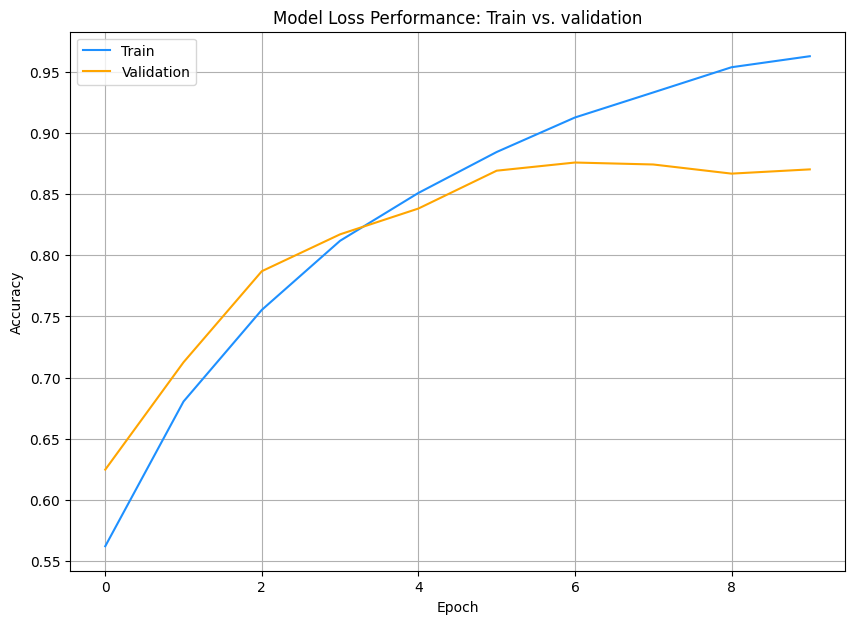

In [200]:
J = history.history['accuracy']  # Loss data for Training 
J_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

#### Plot the accuracy data, for both train and validation data

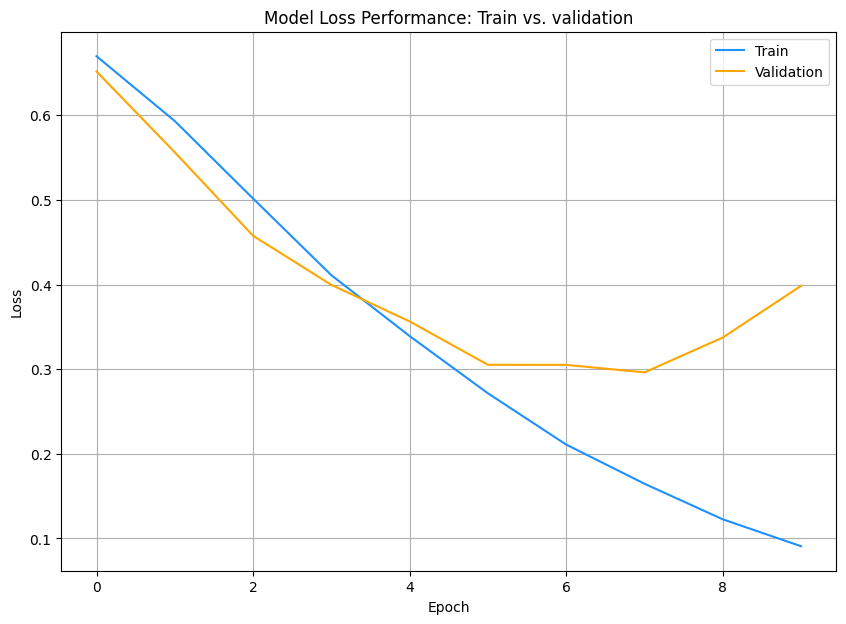

In [201]:
J = history.history['loss']  # Loss data for Training 
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

## <font color=green>Test the CNN Model</font>
__Note: Display the history when running model.evaluate( )__

### <font color=red>Question: What is the estimated inference (testing) time on test dataset?</font>

<font color = blue>**Answer:** It took 14 seconds to run the inference</font>

### Print the final loss and accuracy of the test data

In [202]:
loss, accuracy = cnn1.evaluate(test_data, verbose=1)

y_pred = cnn1.predict(test_data)

print("Accuracy: ", round(accuracy * 100, 2), "%")
print("Loss: ", round(loss, 2))

98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8704 - loss: 0.4311
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step
Accuracy:  87.55 %
Loss:  0.4


### Save the CNN model parameters

In [206]:
cnn1.save('./cnn1.keras')

# <font color=blue>Build CNN Model Two</font>

__For your second and subsequent models, follow the same set of instructions provided for Model One__

In [209]:
# ----------- Target Picture Size ------------ #
target_pic_size = (128, 128)                     #
target_pic_shape = target_pic_size + (3,)      #
# -------------------------------------------- #

train_data = datagen.flow_from_directory(train_dir + '/train',
            class_mode='binary', batch_size=64, target_size=target_pic_size)

val_data = datagen.flow_from_directory(train_dir + '/validation',
           class_mode='binary', batch_size=64, target_size=target_pic_size)

test_data = datagen.flow_from_directory(train_dir + '/test',
            class_mode='binary', batch_size=64, target_size=target_pic_size)


cnn2 = Sequential()

cnn2.add(Conv2D(64, (3,3), activation= 'relu', input_shape = target_pic_shape))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Flatten())

cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dense(1, activation='sigmoid'))

Found 15000 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


In [210]:
cnn2.summary()

Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_285 (Conv2D)             │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_189               │ (None, 63, 63, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_70 (Flatten)            │ (None, 254016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 128)            │    32,514,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,516,097 (124.04 MB)

 Trainable params: 32,516,097 (124.04 MB)

 Non-trainable params: 0 (0.00 B)

In [211]:
cnn2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = cnn2.fit(train_data, epochs=10, batch_size=64, validation_data=val_data, verbose=1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 64s 267ms/step - accuracy: 0.5953 - loss: 1.9527 - val_accuracy: 0.7352 - val_loss: 0.5331
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 54s 229ms/step - accuracy: 0.7920 - loss: 0.4470 - val_accuracy: 0.7411 - val_loss: 0.5374
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 54s 227ms/step - accuracy: 0.8615 - loss: 0.3232 - val_accuracy: 0.7304 - val_loss: 0.5988
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 54s 227ms/step - accuracy: 0.9232 - loss: 0.2082 - val_accuracy: 0.7277 - val_loss: 0.6686
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 56s 236ms/step - accuracy: 0.9617 - loss: 0.1234 - val_accuracy: 0.7224 - val_loss: 0.8065
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 55s 233ms/step - accuracy: 0.9841 - loss: 0.0669 - val_accuracy: 0.7291 - val_loss: 0.8559
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 56s 237ms/step - accuracy: 0.9914 - loss: 0.0437 - val_accuracy: 0.7163 - val_loss: 1.1062
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 55s 233ms/step - accuracy: 0.9958 - loss: 0.0243 - val

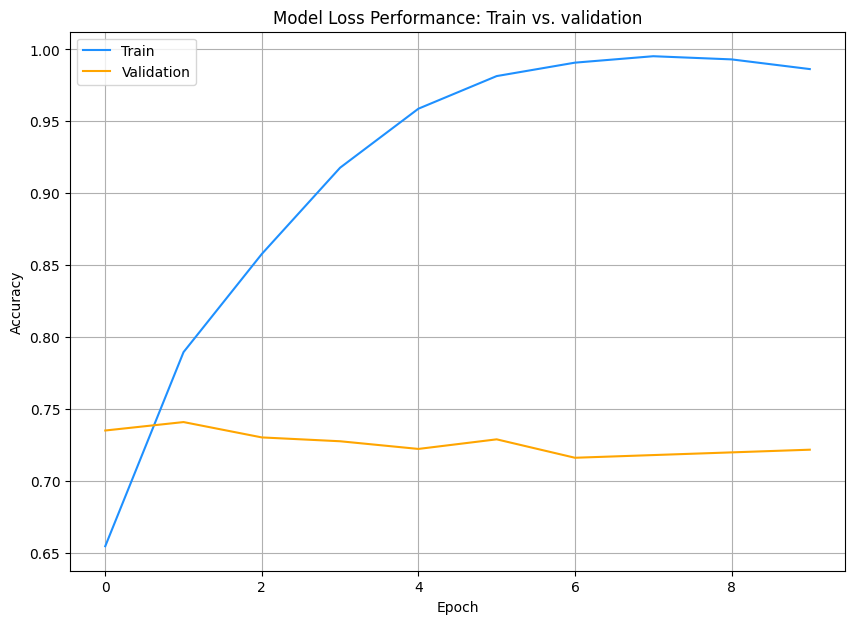

In [212]:
J = history.history['accuracy']  # Loss data for Training 
J_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

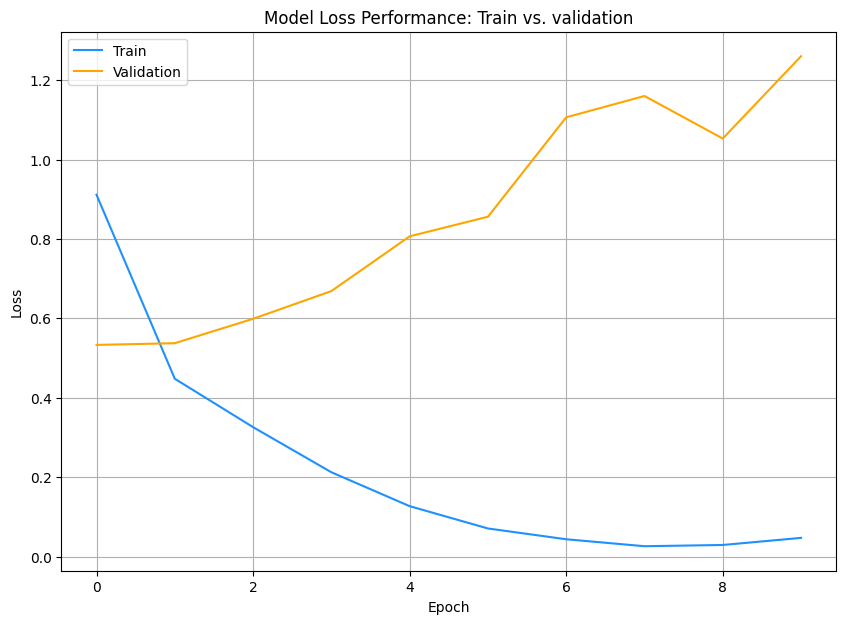

In [213]:
J = history.history['loss']  # Loss data for Training 
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

In [214]:
loss, accuracy = cnn2.evaluate(test_data, verbose=1)

y_pred = cnn2.predict(test_data)

print("Accuracy: ", round(accuracy * 100, 2), "%")
print("Loss: ", round(loss, 2))

 2/98 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.7891 - loss: 1.0680  

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.7280 - loss: 1.2050
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step
Accuracy:  72.8 %
Loss:  1.22


## <font color=green>Conclusion</font>

### You will fill out information in this table:
| Model              | Accuracy | Number of Parameters | Training Time | Inference Speed |
|-------------------- |----------|-----------------------|--------------- |------------------|
| Baseline VGG-5     |          |                       |                |                  |
| Model One           |          |                       |                |                  |
| Model Two           |          |                       |                |                  |
| Model Three         |          |                       |                |                  |


__Please add comments on what you tried and observed while working on the assignment.__

## <center><font color=maroon>Remember to turn in both the notebook and the pdf version.</font></center>